# **GMM's**

Notebook adaptado por: Jonnatan Arias Garcia

email: jonnatan.arias@utp.edu.co - jariasg@uniquindio.edu.co

# In Depth: Gaussian Mixture Models

Los clusters Kmenas vistos anteriormente son relativamente faciles de entender, pero implicand manejar retos practicos en su aplicacion.

En particular, los naturaleza no probabilista de kMeans usa simplemente la distancia del centro de un cluster a los miembros mismos, manejando un desempeño pobre en situaciones del mundo real.

En este capitulo, miraremos las Gaussian mixture models, las cuales pueden ser vistas como una extension de las ideas detras de k-means, peto siendo una herramienta mas poderosa de estimacion tras el simple clustering.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

<ipython-input-1-cd9e54b682e8>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## Moticación de los Gaussian Mixtures: Debilidad del k-Means

Miremos algunas debilidades de K-means y pensemos como podriamos mejorar el modelo de cluster.

Anteriormente, vimos que kmeans, dada una data simple y bien preparada, encuentra clusters apropiados.

Por ejemplo, si tenemos la base de datos blobs, kmeans puede encontrar rapidamente los cluster de forma similar a como lo hariamos a simple vista.


In [2]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


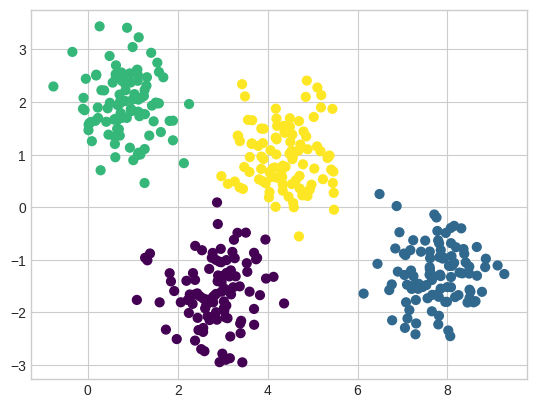

In [3]:
# Plot the data with k-means labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Desde un punto de vista intuitivo, podríamos esperar que la asignación de agrupación para algunos puntos sea más segura que para otros: por ejemplo, parece haber una ligera superposición entre los dos grupos del medio, de modo que es posible que no tengamos completa confianza en la asignación del grupo de puntos entre ellos. Desafortunadamente, el modelo de k-medias no tiene una medida intrínseca de probabilidad o incertidumbre en las asignaciones de los grupos (aunque puede ser posible utilizar un enfoque de bootstrap para estimar esta incertidumbre).


Para esto, debemos pensar en generalizar el modelo.
Una forma de pensar en el modelo de k-medias es que coloca un círculo (o, en dimensiones superiores, una hiperesfera) en el centro de cada grupo, con un radio definido por el punto más lejano en el grupo. Este radio actúa como un límite estricto para la asignación de grupos dentro del conjunto de entrenamiento: cualquier punto fuera de este círculo no se considera miembro del grupo.

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, ec='black', fc='lightgray',
                                lw=3, alpha=0.5, zorder=1))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


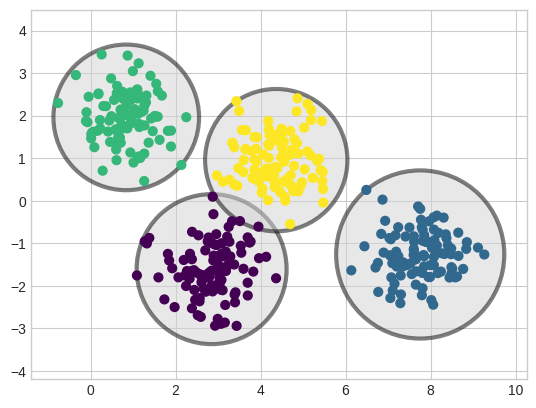

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

Una observación importante para k-medias es que estos modelos de agrupación deben ser circulares: k-medias no tiene una forma incorporada de tener en cuenta grupos oblongos o elípticos. Entonces, por ejemplo, si tomamos los mismos datos y los transformamos, las asignaciones de los grupos terminan siendo confusas, como se puede ver en la siguiente figura:

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


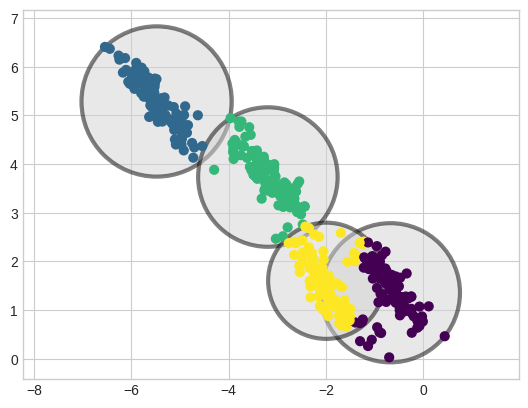

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

A simple vista, reconocemos que estos grupos transformados no son circulares, por lo que los grupos circulares serían una mala opción. Sin embargo, *k*-medias no es lo suficientemente flexible como para tener en cuenta esto e intenta ajustar los datos a cuatro grupos circulares.
Esto resulta en una mezcla de asignaciones de grupos donde los círculos resultantes se superponen: especialmente se puede ver en la parte inferior derecha de este gráfico. Se podría imaginar abordar esta situación en particular preprocesando los datos con PCA, pero en la práctica no hay garantía de que tal operación global circularice los grupos individuales.

Estas dos desventajas de *k*-medias, su falta de flexibilidad en la forma de los grupos y la falta de asignación de grupos probabilística, significan que para muchos conjuntos de datos (especialmente conjuntos de datos de baja dimensionalidad) puede que no funcione tan bien como se podría esperar.

Se podría imaginar abordar estas debilidades generalizando el modelo de *k*-medias: por ejemplo, se podría medir la incertidumbre en la asignación de grupos comparando las distancias de cada punto a todos los centros de los grupos, en lugar de centrarse solo en el más cercano. También se podría imaginar permitir que los límites de los grupos sean elipses en lugar de círculos, para tener en cuenta grupos no circulares. Resulta que estos son dos componentes esenciales de un tipo diferente de modelo de agrupación, los modelos de mezcla gaussiana.

## Generalización de E–M: Gaussian Mixture Models

Un modelo de mezcla gaussiana intenta encontrar una mezcla de distribuciones de probabilidad gaussiana multidimensionales que mejor modele cualquier conjunto de datos de entrada.

En el caso más simple, los GMM se pueden utilizar para encontrar grupos de la misma manera que *k*-medias (ver la siguiente figura):

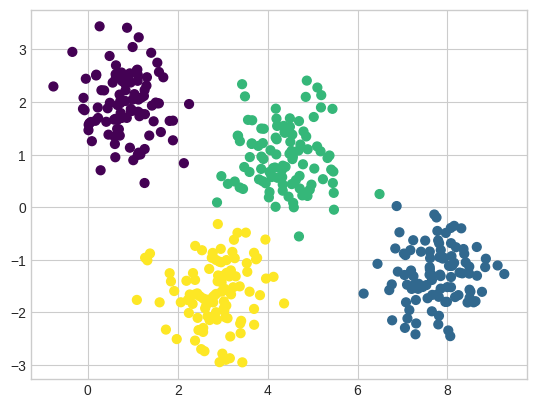

In [7]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

Pero debido a que un GMM contiene un modelo probabilístico en su interior, también es posible encontrar asignaciones de grupos probabilísticas;

en Scikit-Learn, esto se hace utilizando el método predict_proba. Esto devuelve una matriz de tamaño `[n_muestras, n_grupos]` que mide la probabilidad de que cualquier punto pertenezca al grupo dado:

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.463 0.537 0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    1.    0.   ]
 [0.    0.    0.    1.   ]]


Podemos visualizar esta incertidumbre, por ejemplo, haciendo que el tamaño de cada punto sea proporcional a la certeza de su predicción;
al observar la siguiente figura, podemos ver que son precisamente los puntos en los límites entre los grupos los que reflejan esta incertidumbre en la asignación de grupos:

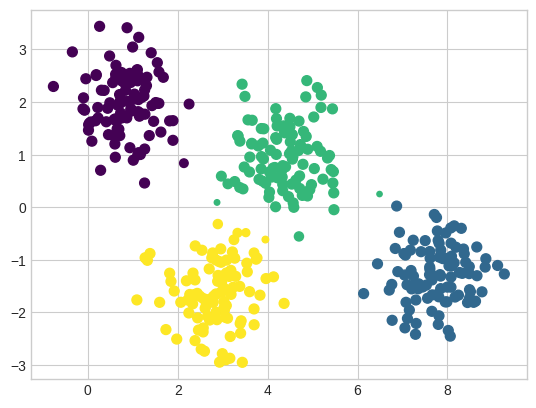

In [9]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Bajo la superficie, un modelo de mezcla gaussiana es muy similar a *k*-medias: utiliza un enfoque de expectativa-maximización, que cualitativamente hace lo siguiente:

1. Elige estimaciones iniciales para la ubicación y la forma.
2. Repite hasta converger:
   Paso E: Para cada punto, encuentra pesos que codifican la probabilidad de pertenencia a cada grupo.
   Paso M: Para cada grupo, actualiza su ubicación, normalización y forma en función de todos los puntos de datos, haciendo uso de los pesos.


El resultado de esto es que cada grupo no está asociado con una esfera de borde duro, sino con un modelo gaussiano suave. Al igual que en el enfoque de expectativa-maximización de *k*-medias, este algoritmo a veces puede no encontrar la solución óptima global, por lo que en la práctica se utilizan múltiples inicializaciones aleatorias.

Creemos una función que nos ayudará a visualizar las ubicaciones y formas de los grupos GMM dibujando elipses en función de la salida del GMM:

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Draw the ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')

    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

Con esto en su lugar, podemos echar un vistazo a lo que nos da el GMM de cuatro componentes para nuestros datos iniciales (ver la siguiente figura):

<ipython-input-10-72694608e0cc>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


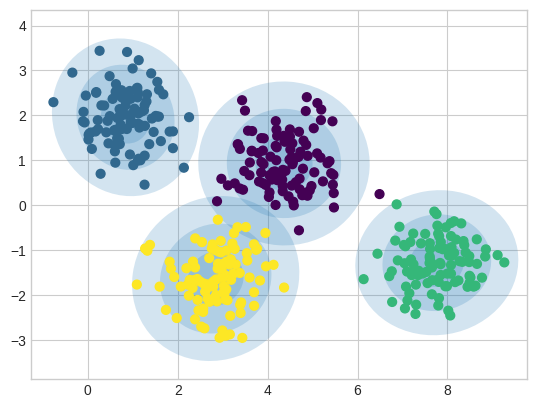

In [11]:
gmm = GaussianMixture(n_components=4, random_state=42)
plot_gmm(gmm, X)

De manera similar, podemos usar el enfoque de GMM para ajustar nuestro conjunto de datos estirado; permitiendo una covarianza completa, el modelo ajustará incluso grupos muy oblongos y estirados, como se puede ver en la siguiente figura:

<ipython-input-10-72694608e0cc>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


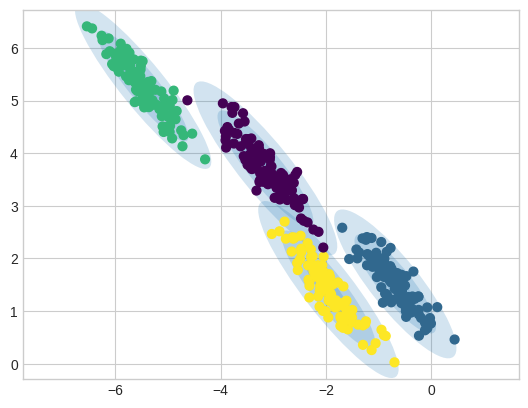

In [12]:
gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

Esto deja claro que los GMM abordan los dos principales problemas prácticos con *k*-medias encontrados anteriormente.

## Al elegir el Tipo de Covarianza

Si observas los detalles de los ajustes anteriores, verás que la opción `covariance_type` se configuró de manera diferente en cada uno. Este hiperparámetro controla los grados de libertad en la forma de cada grupo; es esencial configurarlo cuidadosamente para cualquier problema dado.

El valor predeterminado es `covariance_type="diag"`, lo que significa que el tamaño del grupo a lo largo de cada dimensión se puede establecer de forma independiente, con la elipse resultante restringida a alinearse con los ejes.

Un modelo ligeramente más simple y rápido es `covariance_type="spherical"`, que limita la forma del grupo de modo que todas las dimensiones sean iguales. El agrupamiento resultante tendrá características similares a las de *k*-medias, aunque no es completamente equivalente.

El modelo `covariance_type="tied"` tiene configuración donde todas las componentes comparten la misma matriz de covarianza. Esto significa que todas las elipses que representan los grupos tienen la misma forma y tamaño, pero pueden tener diferentes centros y orientaciones

Un modelo más complicado y computacionalmente costoso (especialmente a medida que crece el número de dimensiones) es usar `covariance_type="full"`, que permite modelar cada grupo como una elipse con orientación arbitraria.

Podemos ver una representación visual de estas tres opciones para un solo grupo en la siguiente figura:

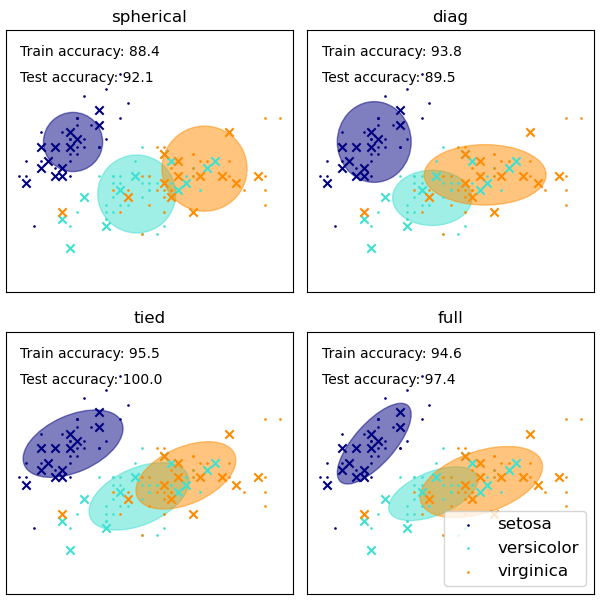\!

## Gaussian Mixture Models como estimador de Densidad

Aunque el GMM a menudo se clasifica como un algoritmo de agrupación, fundamentalmente es un algoritmo para la estimación de densidad.

Es decir, el resultado de un ajuste de GMM a algunos datos técnicamente no es un modelo de agrupación, sino un modelo probabilístico generativo que describe la distribución de los datos.

Como ejemplo, considera algunos datos generados a partir de la función make_moons de Scikit-Learn

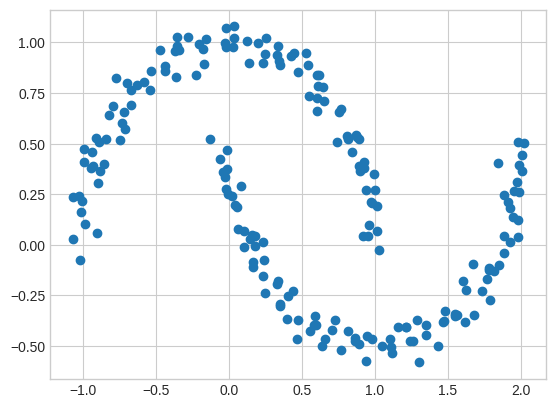

In [13]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Si intentamos ajustar esto con un GMM de dos componentes visto como un modelo de agrupación, los resultados no son particularmente útiles (ver la siguiente figura):

<ipython-input-10-72694608e0cc>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


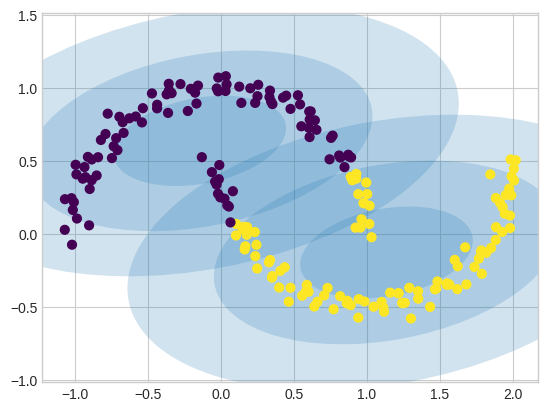

In [14]:
gmm2 = GaussianMixture(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

Pero si en cambio usamos muchos más componentes e ignoramos las etiquetas de los grupos, encontramos un ajuste que se acerca mucho más a los datos de entrada (ver la siguiente figura):

<ipython-input-10-72694608e0cc>:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


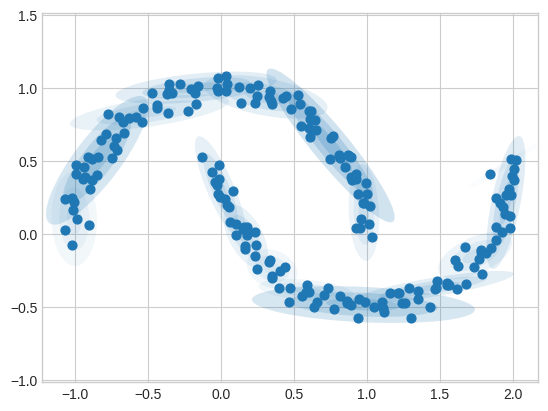

In [15]:
gmm16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Aquí, la mezcla de 16 componentes gaussianos no sirve para encontrar grupos separados de datos, sino más bien para modelar la distribución general de los datos de entrada.

Este es un modelo generativo de la distribución, lo que significa que el GMM nos da la receta para generar nuevos datos aleatorios distribuidos de manera similar a nuestra entrada.

Por ejemplo, aquí hay 400 nuevos puntos dibujados a partir de esta mezcla de 16 componentes GMM ajustada a nuestros datos originales (ver la siguiente figura):

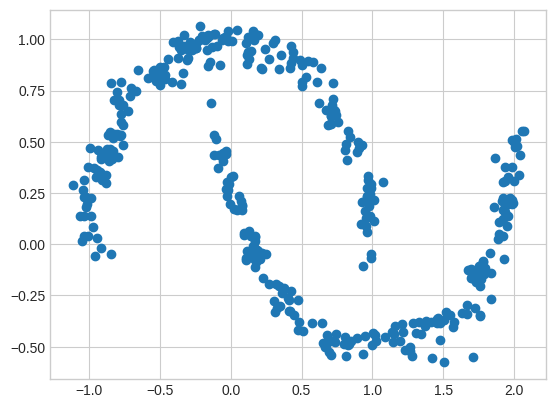

In [16]:
Xnew, ynew = gmm16.sample(400)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

Un GMM es conveniente como un medio flexible para modelar una distribución multidimensional arbitraria de datos.

### ¿Cuántos componentes?

El hecho de que un GMM sea un modelo generativo nos proporciona un medio natural para determinar el número óptimo de componentes para un conjunto de datos dado.

Un modelo generativo es inherentemente una distribución de probabilidad para el conjunto de datos, por lo que simplemente podemos evaluar la verosimilitud de los datos bajo el modelo, utilizando la validación cruzada para evitar el sobreajuste.

Otro medio de corregir el sobreajuste es ajustar las verosimilitudes del modelo utilizando algún criterio analítico como el criterio de información de Akaike (AIC) o el criterio de información bayesiano (BIC). El estimador GaussianMixture de Scikit-Learn incluye en realidad métodos incorporados que calculan ambos, por lo que es muy fácil operar utilizando este enfoque.

Veamos el AIC y el BIC versus el número de componentes GMM para nuestro conjunto de datos de lunas (ver la siguiente figura):

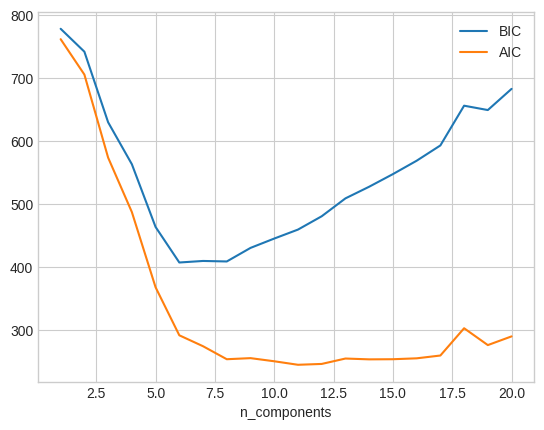

In [17]:
n_components = np.arange(1, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

El número óptimo de grupos es el valor que minimiza el AIC o el BIC, dependiendo de qué aproximación deseemos utilizar. El AIC nos indica que nuestra elección de 16 componentes anterior probablemente fue demasiado: alrededor de 8-12 componentes habría sido una mejor elección. Como es típico en este tipo de problema, el BIC recomienda un modelo más simple.

Observa el punto importante: esta elección del número de componentes mide qué tan bien funciona un GMM como estimador de densidad, no qué tan bien funciona como algoritmo de agrupación. Te animaría a pensar en el GMM principalmente como un estimador de densidad, y usarlo para la agrupación solo cuando sea apropiado en conjuntos de datos simples.

## Ejemplo: GMMs para Generar Nuevos Datos

Acabamos de ver un ejemplo sencillo de usar un GMM como un modelo generativo para crear nuevas muestras de la distribución definida por los datos de entrada. Aquí vamos a seguir con esta idea y generar nuevos dígitos escritos a mano del de la base de datos digts.

Para empezar, carguemos los datos de dígitos usando las herramientas de datos de Scikit-Learn:

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

A continuación, vamos a graficar los primeros 50 de éstos para recordar exactamente a qué nos estamos refiriendo (ver la siguiente figura):

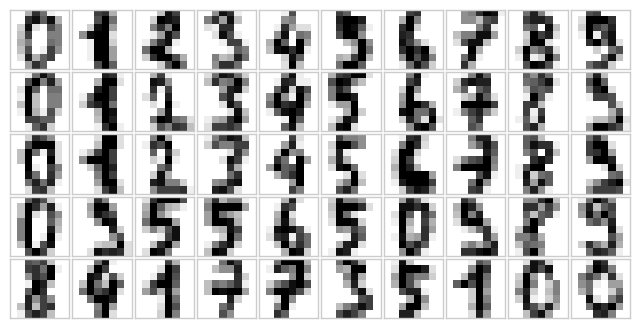

In [19]:
def plot_digits(data):
    fig, ax = plt.subplots(5, 10, figsize=(8, 4),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Tenemos casi 1,800 dígitos en 64 dimensiones, y podemos construir un GMM encima de estos para generar más.

Los GMM pueden tener dificultades para converger en un espacio de tan alta dimensión, por lo que comenzaremos con un algoritmo de reducción de dimensionalidad invertible en los datos. Aquí utilizaremos un PCA directo, pidiéndole que preserve el 99% de la varianza en los datos proyectados:

In [20]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

El resultado es de 41 dimensiones, una reducción de casi 1/3 con casi ninguna pérdida de información. Dados estos datos proyectados, usemos el AIC para tener una idea del número de componentes de GMM que deberíamos usar (ver la siguiente figura):

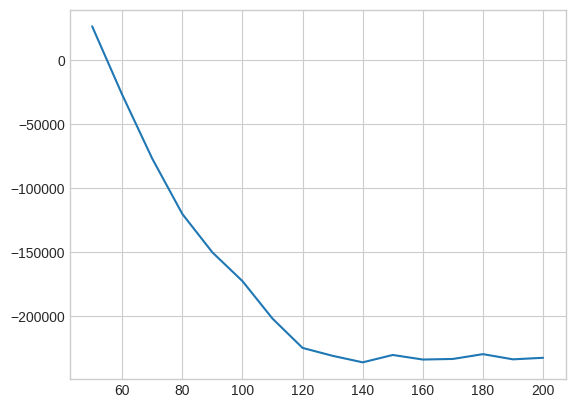

In [21]:
n_components = np.arange(50, 210, 10)
models = [GaussianMixture(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

Parece que alrededor de 140 componentes minimizan el AIC; usaremos este modelo. Vamos a ajustarlo rápidamente a los datos y confirmar que ha convergido.

In [22]:
gmm = GaussianMixture(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


Ahora podemos dibujar muestras de 100 nuevos puntos dentro de este espacio proyectado de 41 dimensiones, usando GMM como un modelo generativo:

In [23]:
data_new, label_new = gmm.sample(100)
data_new.shape

(100, 41)

Finalmente, podemos usar la transformación inversa del objeto PCA para construir los nuevos dígitos (consulte la siguiente figura):

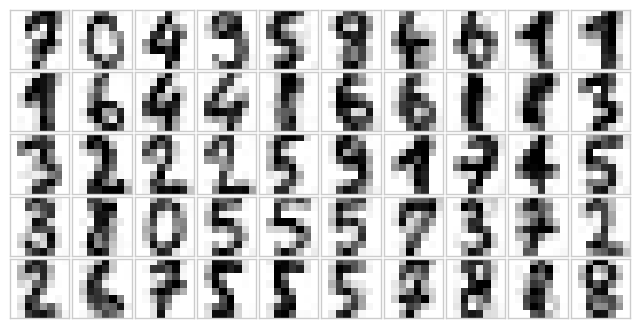

In [24]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

Los resultados en su mayoría parecen dígitos plausibles del conjunto de datos!

Considera lo que hemos hecho aquí: dado un muestreo de dígitos escritos a mano, hemos modelado la distribución de esos datos de tal manera que podemos generar nuevas muestras de dígitos a partir de los datos: estos son "dígitos escritos a mano", que no aparecen individualmente en el conjunto de datos original, sino que capturan las características generales de los datos de entrada como se modela en el modelo de mezcla.